In [1]:
#import packages
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.layers import Input, Flatten, Concatenate, Embedding, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import LabelEncoder, StandardScaler
from numpy.lib.stride_tricks import sliding_window_view
from keras_efficient_kan import KANLinear
import keras
from keras import ops
from tensorflow.keras import layers, models
from tensorflow.keras.layers import LSTM, Dense, Input, Embedding, Flatten, Concatenate, Dropout
from tensorflow.keras.callbacks import EarlyStopping

In [6]:
model = keras.models.load_model('../model_testing/forecast_lstm__kan_balanced.keras')

In [ ]:
from tensorflow.keras.utils import plot_model

plot_model(model, to_file="../report/figures/model_summary/logistic_6.png", show_shapes=True)


In [3]:
WEATHER_CSV = "../data/clean/valais_clean.csv"
STATIONS_CSV = "../data/clean/valais_stations.csv"

HIST_LEN = 36      # 6 hours history @ 10-minute freq
HORIZON = 6        # predict 1 hour ahead (6 * 10 minutes)
BATCH_SIZE = 256
EPOCHS = 10
SPLIT_FRACTION = 0.8
LEARNING_RATE = 0.001

# ── LOAD & PREP DATA ─────────────────────────────
df_weather = pd.read_csv(WEATHER_CSV)
df_weather["time"] = pd.to_datetime(df_weather["time"], format="%Y%m%d%H%M")

df_stations = pd.read_csv(STATIONS_CSV)
df = df_weather.merge(df_stations[["station", "east", "north", "altitude"]], on="station", how="left")
df = df[df["station"] == "SIO"]

# ── NORMALIZE ────────────────────────────────────
selected_features = ['precip', 'temperature', 'East', 'North', 'pressure', 'moisture']
features = df[selected_features]
features.index = df["time"]

train_split = int(SPLIT_FRACTION * len(features))
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)
features = pd.DataFrame(features_scaled, index=features.index, columns=selected_features)

x = []
y = []

# ── CREATE SAMPLES ───────────────────────────────
for i in range(HIST_LEN, len(features) - HORIZON):
    x.append(features.iloc[i - HIST_LEN:i].values)
    y.append(features.iloc[i + HORIZON]["precip"])  # forecast rain

x = np.array(x)
y = np.array(y)

split_idx = int(SPLIT_FRACTION * len(x))
x_train, x_val = x[:split_idx], x[split_idx:]
y_train, y_val = y[:split_idx], y[split_idx:]

In [7]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, confusion_matrix, ConfusionMatrixDisplay
import numpy as np
import matplotlib.pyplot as plt

# ── PREDICT ───────────────────────────────────────────────
y_pred = model.predict(x_val).flatten()  # or x_test if you have separate test set

# ── EVALUATE REGRESSION METRICS ───────────────────────────
mse = mean_squared_error(y_val, y_pred)
mae = mean_absolute_error(y_val, y_pred)

print(f"Mean Squared Error: {mse:.4f}")
print(f"Mean Absolute Error: {mae:.4f}")

1644/1644 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step
Mean Squared Error: 1.3995
Mean Absolute Error: 0.2904


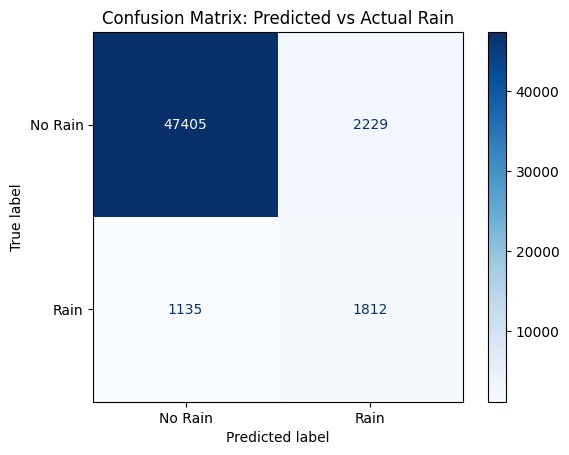

In [9]:
# ── DEFINE THRESHOLD ──────────────────────────────────────
RAIN_THRESHOLD = 0.1

# ── CONVERT TO BINARY CLASSES ─────────────────────────────
y_true_binary = (y_val >= RAIN_THRESHOLD).astype(int)
y_pred_binary = (y_pred >= RAIN_THRESHOLD).astype(int)

# ── CONFUSION MATRIX ──────────────────────────────────────
cm = confusion_matrix(y_true_binary, y_pred_binary, labels=[0, 1])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["No Rain", "Rain"])

disp.plot(cmap="Blues")
plt.title("Confusion Matrix: Predicted vs Actual Rain")
plt.grid(False)
plt.show()
